In [3]:
import tifffile
import skimage
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.segmentation import mark_boundaries
from shapely.geometry import Polygon

In [8]:
path1 = 'data/High_res_mask.tif'
high_res = tifffile.imread(path1)

scale = 11.77/ 60

# dowinsizing to 60 microns 
downsized_mask = skimage.transform.rescale(high_res, scale, order=None, mode='reflect',
                                           cval=0, clip=True, preserve_range=True,anti_aliasing=None,
                                           anti_aliasing_sigma=None,channel_axis=None)


Text(0.5, 1.0, 'Downsized Histogram')

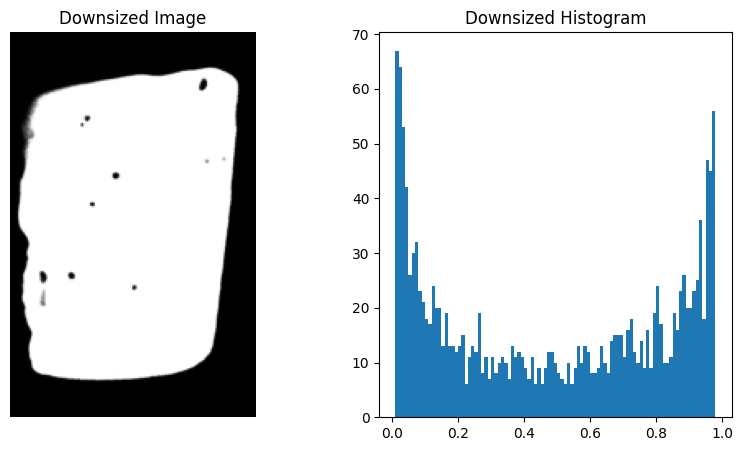

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the images on the subplots
axs[0].imshow(downsized_mask[0],'gray')
axs[0].set_title('Downsized Image')
axs[0].axis('off')

axs[1].hist(downsized_mask[0].ravel(), bins=np.array([i for i in range (1,99)])/100)
axs[1].set_title('Downsized Histogram')

# Now we need to find a threshold based on the Porosity


In [26]:
def remove_casing (img,threshold, epsilon):
    #Threshholding 
    ret,thresh = cv.threshold(img,threshold,1,cv.THRESH_BINARY)
    thresh = thresh.astype('uint8')
    # Finding contours for the thresholded image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    contour = contours[0] #biggest outside contour
    #cnt_draw = cv.cvtColor(img,cv.COLOR_GRAY2RGB) only for visulization on color 
    mask = np.zeros_like(img)
    
    #Step_2 removing the Casing
    polygon = Polygon(contour[:, 0, :])

    # Compute offset
    offset_polygon = polygon.buffer(-epsilon)

    # Convert offset polygon to numpy array and draw on image
    points = np.array(offset_polygon.exterior.coords)
    points = np.expand_dims(points.astype(np.int32), axis=1)
    
    cv.drawContours(mask, [points], -1, 100, -1 )
    
    #filtering
    output = img.copy()
    output[mask == 0] = 0

    return output, mask

In [27]:
# Generating a mask for obtaining the pixels inside the specimen body
border_mask_high_res = np.zeros_like(high_res)
for i in range (high_res.shape[0]):
    img = high_res[i]*10
    try:
        _, border_mask_high_res[i] = remove_casing(img, 7, 4)
    except:
        border_mask_high_res[i] = border_mask_high_res[i-1]
        #print('Mask in thes layer has issue',i)


In [29]:
# Generating a mask for obtaining the pixels inside the specimen body
border_mask_low_res = np.zeros_like(downsized_mask)
for i in range (downsized_mask.shape[0]):
    img = downsized_mask[i]*10
    _, border_mask_low_res[i] = remove_casing(img, 8, 2)

In [30]:
prosity_list = []
i_list = []
for i in range (10,80):
    prosity_list.append(100*downsized_mask[(downsized_mask<i/100)&(border_mask_low_res>0)].shape[0]/border_mask_low_res[border_mask_low_res>0].shape[0])
    i_list.append(i/100)

In [33]:
high_res_prosity=   100*high_res[(high_res==0)&(border_mask_high_res>0)].shape[0]/border_mask_high_res[border_mask_high_res>0].shape[0]
low_res_50_prosity= 100*downsized_mask[(downsized_mask<0.56)&(border_mask_low_res>0)].shape[0]/border_mask_low_res[border_mask_low_res>0].shape[0]

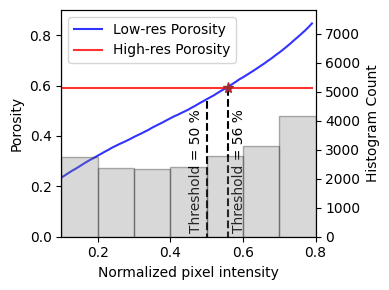

In [72]:

plt.figure(figsize=(4, 3))
plt.plot(i_list,prosity_list, color = 'Blue', label = 'Low-res Porosity', alpha = 0.8)
plt.plot(i_list, [high_res_prosity for i in i_list], color = 'Red', label = 'High-res Porosity', alpha = 0.8)
plt.xlabel('Normalized pixel intensity')
plt.ylabel('Porosity')

x_collision = 0.50
y_collision = 0.54

# Plotting the dashed line
plt.plot([x_collision, x_collision], [y_collision, 0],  linestyle='--', color = 'black')
plt.text(x_collision-0.03, 0.26, f'Threshold = {int(x_collision*100)} %', ha='center', va='center',rotation=90)

x_collision = 0.56
y_collision = 0.59

# Plotting the dashed line
plt.plot([x_collision, x_collision], [y_collision, 0],  linestyle='--', color = 'black')



# Adding the text annotation
plt.text(x_collision+0.03, 0.26, f'Threshold = {int(x_collision*100)} %', ha='center', va='center',rotation=90)
plt.plot(x_collision, y_collision, marker='*', markersize=8, color='Brown')
plt.legend()
plt.xlim(0.1,0.8)
plt.ylim(0,0.9)


# Plot the histogram
# Create a second y-axis
ax2 = plt.twinx()

# Plot a line plot with the histogram values on the second y-axis
ax2.hist(downsized_mask[border_mask_low_res > 0].ravel(), bins = np.array([i for i in range (0,9)])/10,
         color = 'tab:gray', edgecolor = 'black', alpha = 0.3, zorder = 1)

# Customize the appearance of the second y-axis
ax2.set_ylabel('Histogram Count')
ax2.tick_params(axis='y', colors='black')
ax2.spines['right'].set_color('black')
ax2.yaxis.label.set_color('black')

ax2.set_zorder(1)

plt.tight_layout()
plt.savefig('Thresholding.pdf', dpi=400)